## KDJ

KDJ 是一种常用的技术指标，用于衡量市场超买超卖状况和价格动量，主要由三条线组成，分别为 K 线、D 线和 J 线。
下面简单介绍各个部分：

+ K 值：类似于随机指标 (RSV)，反映近期价格相对于最近一段时间内最高价和最低价的位置。计算方式一般为：

  K = (当日收盘价 - N 日内最低价) / (N 日内最高价 - N 日内最低价) × 100

+ D 值：通常是 K 值的平滑移动平均，可以理解为短期趋势的平均值，一般取 K 的 3 日简单移动平均。

+ J 值：是 K 和 D 的扩展指标，用来反映动量的极端值，计算公式常为：

  J = 3 × K - 2 × D

因 J 值对 K 和 D 更敏感，所以常常用来捕捉趋势的转折点。

#### 主要用途和意义：
+ 当 K 、D、 J 都较低时（例如低于 20），市场处于超卖状态；当两线相互交叉时可能暗示买入信号。
+ 当 K、D、J 都较高时（例如高于 80），市场处于超买状态；两线交叉可能暗示卖出信号。
J 值由于波动较大，可以更敏锐地捕捉超买超卖的极端情况。
总之，KDJ 指标兼顾短期动量和趋势平滑效果，在判断市场转折和趋势强度时具有参考价值。

KDJ是一个灵敏的短线指标，适合震荡行情中捕捉买卖点，但在强趋势行情中可能失效，需要结合其他指标综合判断。你是短线还是长线交易？可以根据你的交易风格调整KDJ的使用方法。



In [41]:
# 获取数据源
import baostock as bs
import pandas as pd
import logging
import numpy as np

def get_k_data(code, start, end):
    lg = bs.login()
    # 显示登陆返回信息
    logging.info('login respond error_code:' + lg.error_code)
    logging.info('login respond  error_msg:' + lg.error_msg)
    # 获取股票数据
    rs = bs.query_history_k_data_plus(code,
                                              "date,open,high,low,close,volume",
                                              start_date=start,
                                              end_date=end,
                                              frequency="d",
                                              adjustflag="3")  # adjustflag="3"表示不复权
    data = rs.get_data()


    # 登出baostock系统
    bs.logout()

    # 创建DataFrame
    df = data[['date', 'open', 'high', 'low', 'close', 'volume']].rename(columns={'date': 'Date'})

    # 转换日期格式
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)  # 设置日期列为索引

    # 将空字符串替换为 NaN
    df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].replace('', np.nan)
    # 去除包含空值的行
    df = df.dropna(subset=['open', 'high', 'low', 'close', 'volume'])

    # 将股价数据转换为数值类型
    df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].astype(float)
    return df

In [42]:
stock_code = "sh.603486"  
start_date = "2024-01-01"
end_date = "2025-12-31"

df = get_k_data(stock_code, start_date, end_date)

login success!
logout success!


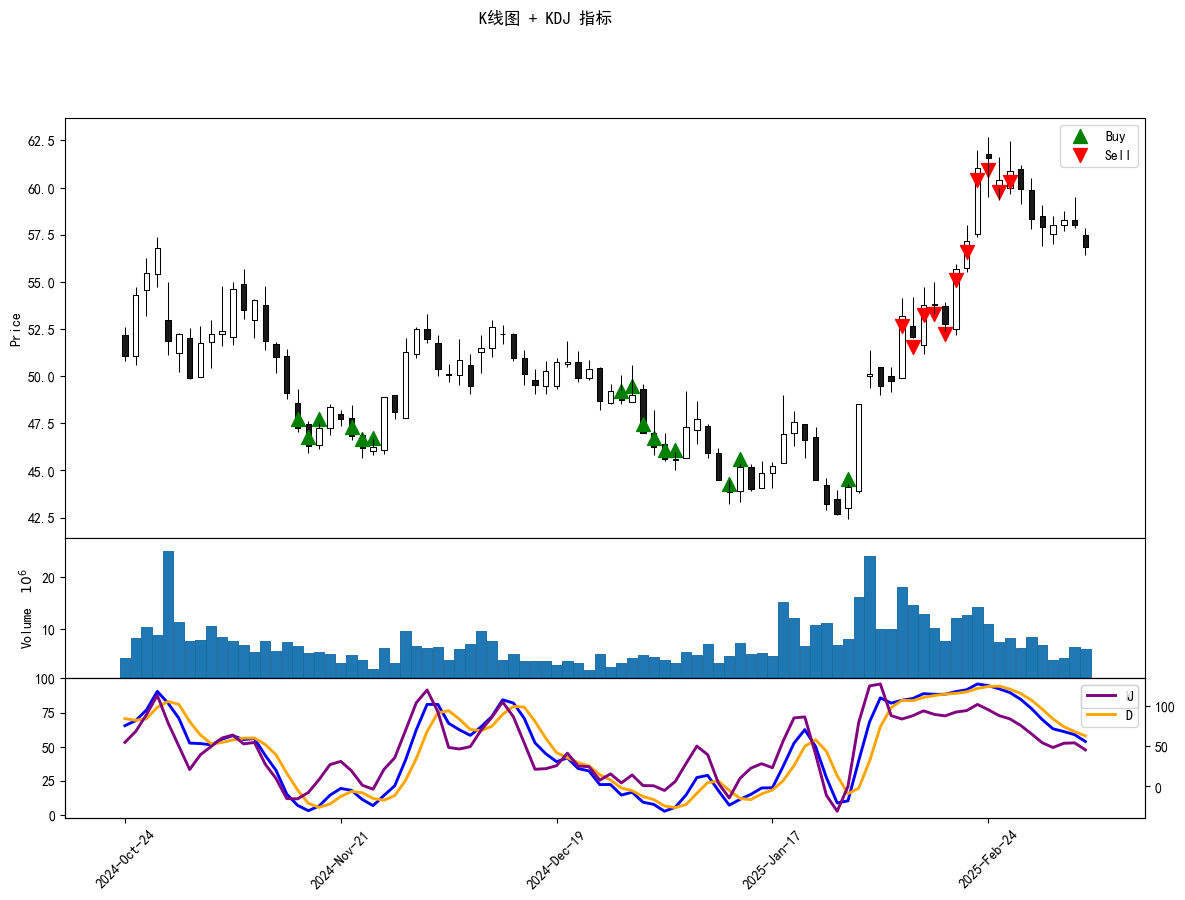

In [43]:
import talib
import mplfinance as mpf
import matplotlib.pyplot as plt


# 使用 talib.STOCH 计算 %K 和 %D（这里选择常用参数：14, 3, 3），
# %K 即为 K 值，%D 即为 D 值
df['K'], df['D'] = talib.STOCH(df['high'], df['low'], df['close'],
                               fastk_period=14, slowk_period=3, slowk_matype=0,
                               slowd_period=3, slowd_matype=0)
# 计算 J 值
df['J'] = 3 * df['K'] - 2 * df['D']


# 标记买卖点：
# 当 K 由下向上突破 D，视为买点；当 K 由上向下穿过 D，则视为卖点
df['buy_signal'] = (df['K'] < 20) & (df['D'] < 20) & (df['J'] < 20)
df['sell_signal'] = (df['K']> 80) & (df['D'] > 80) & (df['J'] > 80)

# 对于主图标记，用收盘价作为基础，并加一点偏移量，以免标记被K线遮挡
df['buy_points'] = np.where(df['buy_signal'], df['close'] * 1.01, np.nan)
df['sell_points'] = np.where(df['sell_signal'], df['close'] * 0.99, np.nan)


df = df.tail(90)

# 创建附加图，用于显示 KDJ 指标 在第二个面板（panel=1）中
ap_k = mpf.make_addplot(df['K'], panel=2, color='blue', label='K')
ap_d = mpf.make_addplot(df['D'], panel=2, color='orange', label='D')
ap_j = mpf.make_addplot(df['J'], panel=2, color='purple', label='J')
ap_buy = mpf.make_addplot(df['buy_points'], panel=0, type='scatter', markersize=100, marker='^', color='g', label='Buy')
ap_sell = mpf.make_addplot(df['sell_points'], panel=0, type='scatter', markersize=100, marker='v', color='r', label='Sell')

# 将附加图放入列表中
apds = [ap_k, ap_d, ap_j,ap_buy, ap_sell]

# 创建自定义风格，设置中文字体
my_style = mpf.make_mpf_style(rc={'font.sans-serif': ['SimHei'],
                                  'axes.unicode_minus': False})


# 绘制图表：上部分为 K 线图（包含成交量），下部分为 KDJ 指标面板
mpf.plot(df, type='candle', style=my_style, addplot=apds, volume=True, figsize=(15,10),
         title="K线图 + KDJ 指标", panel_ratios=(3,1))


plt.show()